In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
INJECTION_DATA_DIR = Path('data/inj/')
PORE_PRESSURE_DATA_DIR = Path('data/pp/')
ETAS_DATA_DIR = Path('data/etas1/')

In [3]:

def parse_year_month(year_month):
    year = int(np.floor(year_month))
    month_dec = np.round(year_month - year, 2)
    month_int = int(np.round(month_dec * 12))
    return [year, month_int]

In [4]:

def parse_pp_data(filename):
    """
    Returns longitude, lattitude, pore pressure dataframe for a given pore pressure data file
    """    
#     print(filename)
    df_pp = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'pp'])
    df_pp = df_pp.groupby('year_month').agg(sum).reset_index()
#     # convert year_month from decimal format to year, month integer format
#     x = df_pp.year_month.apply(parse_year_month)
#     df_temp = pd.DataFrame(x.to_list(), columns=['year', 'month'])
#     df_pp = pd.concat([df_temp, df_pp], axis=1)

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_pp


In [5]:
# prepare pore pressure data
pore_pressure_data_files = list(PORE_PRESSURE_DATA_DIR.glob('*.txt'))
pp_lat_lon_data = {}
for filename in pore_pressure_data_files:
    lat, lon, df_pp = parse_pp_data(filename)
    pp_lat_lon_data[lat, lon] = df_pp


In [85]:
def round_month(date, up=True):
    month_decimal = np.array([0., 0.08, 0.17, 0.25, 0.33, 0.42, 0.5 ,0.58, 0.67, 0.75, 0.83, 0.92])
    year_month = 2010 + date/365
    # get only decimal part (month)
    month = year_month % 1
    year = year_month - month
#     print(year_month, year, month)

    # custom rounding
    if up:
        month = month_decimal[month_decimal >= month]
        if len(month):
            month = month[0]
        else:
            # value must be greater than 0.92(last month), so we'll roll over to next year
            year += 1
            month = 0
    else:
        month = month_decimal[month_decimal <= month][-1]
    return year+month

def avg_lambda(row):
    non_zero_count = (row>0).sum()
    if non_zero_count > 0:
        avg_lambda = row.sum()/non_zero_count
    else:
        return np.nan
    return avg_lambda

df_temp = []

def parse_etas1_data(filename):
    global df_temp
    
    df_etas1 = pd.read_csv(filename, delim_whitespace=True, names=['first_event_number', 'last_event_number','starting_date','ending_date','AIC','K','mu'])
    # calculate lambda    
    df_etas1['lambda'] = (df_etas1['last_event_number'] - df_etas1['first_event_number'] + 1) \
                         / (df_etas1['ending_date'] - df_etas1['starting_date'])
    # convert start/end date from dates.float to year/month/date format
    # round up start date
    new_start_date = df_etas1.starting_date.apply(lambda x: round_month(x, up=True))
    # round down end date
    new_end_date = df_etas1.ending_date.apply(lambda x: round_month(x, up=False))

    df_etas1['new_start_date'] = new_start_date
    df_etas1['new_end_date'] = new_end_date

    # convert each row into a separate dataframe
    all_year_month = [2011.  , 2011.08, 2011.17, 2011.25, 2011.33, 2011.42, 2011.5 ,
           2011.58, 2011.67, 2011.75, 2011.83, 2011.92, 2012.  , 2012.08,
           2012.17, 2012.25, 2012.33, 2012.42, 2012.5 , 2012.58, 2012.67,
           2012.75, 2012.83, 2012.92, 2013.  , 2013.08, 2013.17, 2013.25,
           2013.33, 2013.42, 2013.5 , 2013.58, 2013.67, 2013.75, 2013.83,
           2013.92, 2014.  , 2014.08, 2014.17, 2014.25, 2014.33, 2014.42,
           2014.5 , 2014.58, 2014.67, 2014.75, 2014.83, 2014.92, 2015.  ,
           2015.08, 2015.17, 2015.25, 2015.33, 2015.42, 2015.5 , 2015.58,
           2015.67, 2015.75, 2015.83, 2015.92, 2016.  , 2016.08, 2016.17,
           2016.25, 2016.33, 2016.42, 2016.5 , 2016.58, 2016.67, 2016.75,
           2016.83, 2016.92, 2017.  , 2017.08, 2017.17, 2017.25, 2017.33,
           2017.42, 2017.5 , 2017.58, 2017.67, 2017.75, 2017.83, 2017.92,
           2018.  , 2018.08, 2018.17, 2018.25, 2018.33, 2018.42, 2018.5 ,
           2018.58, 2018.67, 2018.75, 2018.83, 2018.92]

    df = pd.DataFrame(all_year_month, columns=['year_month'])
    df = df.set_index('year_month')
    for idx, row in df_etas1.iterrows():
        df[idx] = 0
        new_start_date = 2005.17
        new_end_date = 2016.00
        lbda = 0.050237
        df.loc[(df.index >= row.new_start_date) & \
               (df.index <= row.new_end_date), idx] = row['lambda']
    
    df_temp = df
    
    df_avg_lambda = df.apply(avg_lambda, axis=1)
    # rename column to lamda
    df_avg_lambda.name = 'lambda'
#     df_avg_lambda = df_avg_lambda.rename(columns={0: "lambda"})
    df_avg_lambda = df_avg_lambda.reset_index()

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_etas1, df_avg_lambda


In [23]:
# prepare etas1 mu,K,lambda data
etas1_data_files = list(ETAS_DATA_DIR.glob('*.etas1'))
etas1_lat_lon_data = {}
for filename in etas1_data_files:
    lat,lon,df_etas1, df_avg_lambda = parse_etas1_data(filename)
    etas1_lat_lon_data[lat, lon] = (df_etas1, df_avg_lambda)

In [8]:
def parse_injection_data(filename):
    """
    Returns longitude, lattitude, injection volume dataframe for a given injection volume data file
    """
#     print(filename)
    df_inj = pd.read_csv(filename, sep=' ', header=None, names=['year_month', 'injection_volume'])
    # convert year_month from decimal format to year, month integer format
#     x = df_inj.year_month.apply(parse_year_month)
#     df_temp = pd.DataFrame(x.to_list(), columns=['year', 'month'])
#     df_inj = pd.concat([df_temp, df_inj], axis=1)

    fname_split = filename.stem.split('_')
    return fname_split[1], fname_split[2], df_inj


In [9]:
# prepare injection data
injection_data_files = list(INJECTION_DATA_DIR.glob('*.txt'))
injection_lat_lon_data = {}
for filename in injection_data_files:
    lat, lon, df_inj = parse_injection_data(filename)
    injection_lat_lon_data[lat, lon] = df_inj



In [10]:
# check to make sure we have injection volume, pp and etas data for all the co-ordinates
assert injection_lat_lon_data.keys() == etas1_lat_lon_data.keys()
assert pp_lat_lon_data.keys() == etas1_lat_lon_data.keys()


In [11]:
from IPython.display import display

## Doubts
1. Can I get ETAS value as a continuos function for each month? (From where did you get this data?)
2. There are overlapping ETAS/Lambda value for many years/months. Which one should I consider? or should I do an average?
3. Some co-ordinates only have very few ETAS/Lambda values. And some years might not have ETAS value. What should we do then?
4. Should I consider co-ordinates(lat,lon) as part of input. This means we are kind of training one ML model per 2 deg co-ordinate. If we don't consider the lat,lon data then, we assume that ML model generalizes well across co-ordinates and only depends on inj vol and pp.
5. If we consider all years of data per co-ordinate as one input, we'll only have 53 inputs overall. This is very small data for training ML model. We should think of using a sliding window approach ex: 12 month. This gives us a lot more data to train the ML model. 


In [25]:
def plot_etas_single(ax, df_etas1, column, color):
    
    ax.hlines(y = df_etas1[column], xmin = df_etas1.new_start_date, xmax = df_etas1.new_end_date,
              linewidth=0.5, color=color)

    # triangle in center of hline
    x = df_etas1.new_start_date + ((df_etas1.new_end_date - df_etas1.new_start_date) / 2.0)
    y = df_etas1[column]
    ax.scatter(x, y, marker="^", color=color, s=5)



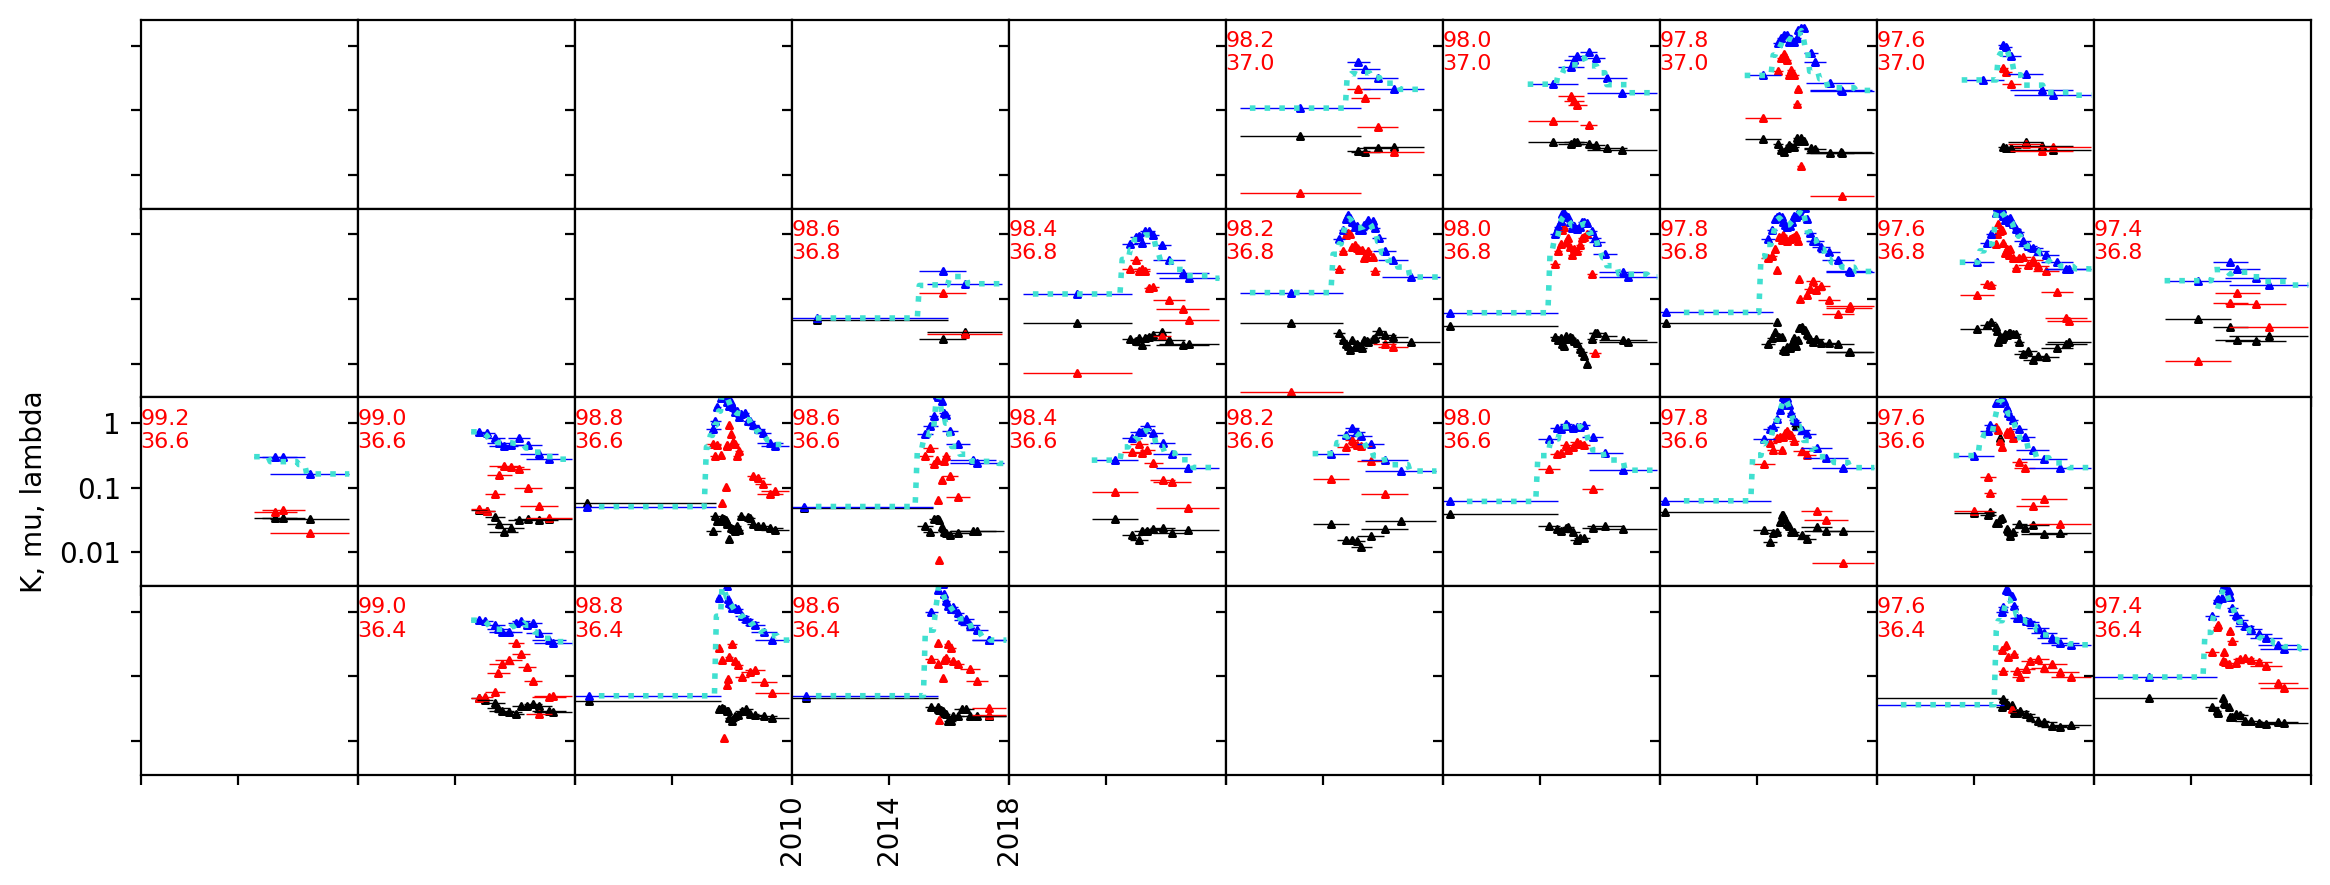

In [86]:
fig, axes = plt.subplots(4, 10, sharex=False, sharey=False, figsize=(14,5), dpi=200)
axes = axes.ravel()

min_k_val = 0.003
max_k_val = 2.5

ax_idx = 0
init=False
for lon in np.arange(37.0, 36.2, -0.2):
    for lat in np.arange(99.2, 97.2, -0.2):
        ax = axes[ax_idx]
        lat_s = "%3.1f"%(lat)
        lon_s = "%3.1f"%(lon)

        if (lat_s,lon_s) in etas1_lat_lon_data:
           #plot etas1 mu,K,lambda
            df_etas1, df_avg_lambda = etas1_lat_lon_data[lat_s, lon_s]
            plot_etas_single(ax, df_etas1, 'K', color='k')
            plot_etas_single(ax, df_etas1, 'mu', color='r')
            plot_etas_single(ax, df_etas1, 'lambda', color='b')
            
            # plot continuos/ average value of lambda
            ax.plot(df_avg_lambda['year_month'], df_avg_lambda['lambda'], 
                    linestyle=':', color='turquoise', linewidth=2)

            # co-ordinate text overlay
            ax.text(2010.00, max_k_val - max_k_val/1.2, '%s\n%s'%(lat_s, lon_s), fontsize=8, color='r')

        # set limit and ticks
        ax.set_yscale("log")
        ax.set_xlim([2010.00, 2018.92])    
        ax.set_ylim([min_k_val, max_k_val])
        yticks = [1, 0.1, 0.01]
        ax.set_yticks(yticks)
        ax.set_xticks([2010.00, 2014.00, 2018.92])
        ax.set_xticklabels([2010, 2014, 2018], rotation=90)

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # injection volume y axis label
        if lat_s == "99.2" and lon_s == "36.6":
            ax.set_yticklabels(yticks, color='k')
            ax.set_ylabel("K, mu, lambda", color='k')            

        if lat_s == "98.6" and lon_s == "36.4":
            ax.set_xticklabels([2010, 2014, 2018])
        
        ax_idx += 1

# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

<AxesSubplot:xlabel='year_month', ylabel='lambda'>

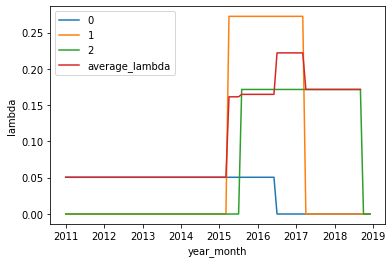

In [87]:
# intermediate plottin of computing average lambda
filename = Path('data/etas1/seism_98.6_36.8_R20_200_50.etas1')
_,_,df_etas_1,df_avg_lambda = parse_etas1_data(filename)

fig, ax = plt.subplots()
df_temp.plot(ax=ax, ylabel='lambda')
df_avg_lambda = df_avg_lambda.rename(columns={'lambda':'average_lambda'})
df_avg_lambda.plot(ax=ax, x='year_month', legend=['average'])

## Case 1: Using Injection Volume and Pore pressure to MLP model, predicting seismicity

### Preparation of Data

In [ ]:
# columns
# lat, lon, year, month, year_month, inj_vol, pp, seismicity

In [89]:
# #def (injection_lat_lon_data,pp_lat_lon_data,df_pp,etas1_lat_lon_data):

# lat, lon = ('96.8', '36.4')

# month_window = 12

# df = injection_lat_lon_data[lat,lon]
# df = df.sort_values(by='year_month')

# # Validation step to make sure each year has exactly 12 months
# twelve_month_check = df.groupby(by='year')['month'].apply(list)\
#             .apply(lambda x: x == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

# if not (twelve_month_check == True).all():
#     print(twelve_month_check)
#     raise Exception("Not all years have 12 months of data")

# # loop through the year_month data 1 month at a time with a window of 12 months
# num_months = df.shape[0]
# for i in range(0, num_months-1, 1):
#     # X ex: we'll take 12 months of data and predict 13th month value
#     inj_vol = df[i: i + month_window].injection_volume
#     pp = df[i: i + month_window].pp
#     # y
#     seismicity = df[i + month_window + 1].seismicity
    
#     # without neighbors
#     # 1 + 1 + 12 + 12 dim
#     X = np.concatenate([lat, lon, inj_vol, pp ]) 
#     # 1 dim
#     y = seismicity
#     yield X, y
    